# Aim

To predict the expected profit for the customers.

In [1]:
'''Definning path of the project'''
path = "D:/customer_quality_prediction/"

# Import Libraries

In [2]:
#importing standard packages
import os
import pandas as pd
import pickle
import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from scipy.stats import shapiro, kruskal
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error 

os.chdir(path)

#importing Functions created for Modeling purpose
exec(open("modeling_functions.py").read())

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [3]:
data = pd.read_csv(path + 'training_csv.csv')

'''
Only picking customers who responded to the campaign because now we want to build a model which can predict profit generated 
by the responded customers
'''

#keeping customers who responded and reseting the index
data = data[data.responded == 'yes'].reset_index(drop = True)

#dropping column 'responded', as it a target variable for a different problem
data.drop(columns = ['responded'], inplace = True)

#id is unique_identifier and profit is our target variable, so dropping them from features dataframe
features_data = data.drop(columns = ['id', 'profit'])

print('This dataset contains {} features for {} customers.'.format(features_data.shape[1], features_data.shape[0]))

#Glimpse of the data
data.head()

This dataset contains 21 features for 928 customers.


,custAge,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,...,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,profit,id
0,NaN,technician,married,professional.course,no,yes,no,cellular,aug,fri,...,nonexistent,1.4,93.444,-36.1,4.964,5228.1,999.0,0,154.0,7311
1,NaN,management,divorced,university.degree,no,no,yes,cellular,nov,fri,...,success,-3.4,92.649,-30.1,0.716,5017.5,0.1,1,464.0,7312
2,57.0,blue-collar,married,unknown,unknown,no,no,telephone,jun,wed,...,nonexistent,1.4,94.465,-41.8,4.959,5228.1,999.0,0,-205.0,7313
3,NaN,admin.,married,high.school,no,yes,no,cellular,oct,NaN,...,failure,-1.1,94.601,-49.5,0.972,4963.6,999.0,3,146.0,7314
4,53.0,technician,married,high.school,no,yes,no,cellular,mar,tue,...,nonexistent,-1.8,93.369,-34.8,0.655,5008.7,999.0,0,151.0,7315


## Features

In [4]:
#Columns in the dataframe
print("Features: \n" + str(list(features_data.columns)))

Features: 
['custAge', 'profession', 'marital', 'schooling', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'campaign', 'pdays', 'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths', 'pastEmail']


### Numeric Variables 

In [5]:
numeric_var = list(features_data._get_numeric_data().columns)
print("Numeric Features: \n" + str(numeric_var))

Numeric Features: 
['custAge', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'pmonths', 'pastEmail']


### Nominal variables

In [6]:
nominal_var = list(set(features_data.columns) - set(numeric_var))
print("Nominal Features: \n" + str(nominal_var))

Nominal Features: 
['loan', 'contact', 'profession', 'default', 'month', 'housing', 'marital', 'day_of_week', 'poutcome', 'schooling']


# Profit: Target variable analysis

analysing the target variable: Customer proft data 

profit: 
Shapiro-Wilk pval:1.1085533357432999e-19
Skewness is 0.21362596230543804

Statistics for Profit: 


count    928.000000
mean     172.112069
std      128.999186
min     -276.000000
25%      124.000000
50%      170.000000
75%      213.250000
max      515.000000
Name: profit, dtype: float64

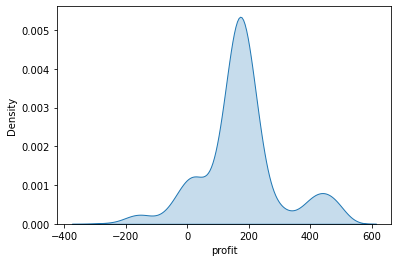

In [7]:
#getting distribution of profit
sns.kdeplot(data=data, x="profit", fill = True)

#Normality test
shapiro_test = shapiro(data['profit'])
print("profit: \nShapiro-Wilk pval:" + str(shapiro_test.pvalue))
print('Skewness is',data['profit'].skew())

print("\nStatistics for Profit: ")
data['profit'].describe()

Profit is not normally distributed (as pval < 0.05, we reject null hypothesis). it is approximately symmetric over mean value. 

# Split Dataset

Splitting dataset at the begining to avoid bias of test set in the model, caused at pre-processing or feature selection step.

NOTE: We will pick the same set of customers for train and test data, splitted during Response Model 

In [8]:
#getting data_train of response model
data_train_response_model = pd.read_pickle(path + "pickle/data_train.p")

#selecting only 'id' present in data_train of response model for Profit Model data_train
data_train = data.merge(data_train_response_model['id'])
data_train.reset_index(drop = True, inplace = True)

#saving as pickle
data_train.to_pickle(path + "pickle_profit/data_train.p")

#getting data_train of response model
data_test_response_model = pd.read_pickle(path + "pickle/data_test.p")

#selecting only 'id' present in data_train of response model for Profit Model data_train
data_test = data.merge(data_test_response_model['id'])
data_test.reset_index(drop = True, inplace = True)

#saving as pickle
data_test.to_pickle(path + "pickle_profit/data_test.p")

print("Train data has {} customers and Test data has {} customers".format(data_train.shape[0], data_test.shape[0]))

Train data has 789 customers and Test data has 139 customers


### Train Data Profit Analysis

profit: 
Shapiro-Wilk pval:1.6613269130443644e-18
Skewness is 0.209956165367957

Statistics for Profit: 


count    789.000000
mean     173.792142
std      128.556294
min     -276.000000
25%      125.000000
50%      171.000000
75%      213.000000
max      509.000000
Name: profit, dtype: float64

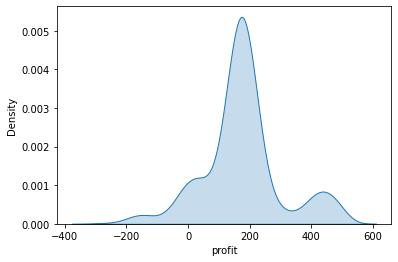

In [9]:
#getting distribution of profit
sns.kdeplot(data = data_train, x="profit", fill = True)

#Normality test
shapiro_test = shapiro(data_train['profit'])
print("profit: \nShapiro-Wilk pval:" + str(shapiro_test.pvalue))
print('Skewness is',data_train['profit'].skew())

print("\nStatistics for Profit: ")
data_train['profit'].describe()

### Test Data Profit Analysis

profit: 
Shapiro-Wilk pval:3.9898677641758695e-05
Skewness is 0.24665188220376583

Statistics for Profit: 


count    139.000000
mean     162.575540
std      131.548414
min     -205.000000
25%      111.500000
50%      161.000000
75%      217.000000
max      515.000000
Name: profit, dtype: float64

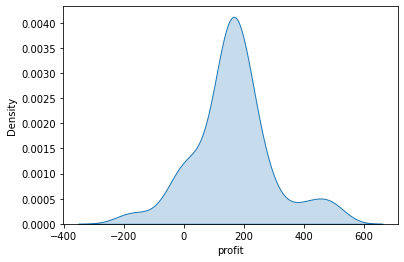

In [10]:
#getting distribution of profit
sns.kdeplot(data = data_test, x="profit", fill = True)

#Normality test
shapiro_test = shapiro(data_test['profit'])
print("profit: \nShapiro-Wilk pval:" + str(shapiro_test.pvalue))
print('Skewness is',data_test['profit'].skew())

print("\nStatistics for Profit: ")
data_test['profit'].describe()

The sampling of Train and Test is uniform (is not biased) and resembles complete data distribution.

#### --------------------------------  From this point, only taking training datset into account as Model population --------------------------------

In [11]:
#loading train data
data_train = pd.read_pickle(path + "pickle_profit/data_train.p")

# Data Pre-processing

## 1. Null Imputation

identifying variables having null and imputing them with certain value.

In [12]:
#getting the count of null for each variable
null_count = data_train.isna().sum()

#getting only the variables with nulls
print("variables having null and count of nulls:")
null_count[null_count > 0]

variables having null and count of nulls:


custAge        199
schooling      238
day_of_week     78
dtype: int64

Above 3 variables have null values, let's handle them

#### Handling custAge

Let's Impute with -999, so that when this variable will be binned and one hot encoded, we will able to study impact of each bucket on target variable.

In [13]:
#imputation as -999, to analyse missing value trend with target variable
data_train['custAge'] = np.where(data_train['custAge'].isna(), -999, data_train['custAge'])

#### handling schooling

In [14]:
#unique catgories in schooling
data_train['schooling'].unique()

array(['professional.course', 'university.degree', 'high.school', nan,
       'basic.9y', 'basic.6y', 'basic.4y', 'unknown'], dtype=object)

In [15]:
#Imputing null with 'unkown' as already there is a bucket called 'unkown'
data_train['schooling'] = np.where(data_train['schooling'].isna(), 'unknown', data_train['schooling'])

#### Handling day_of_week

In [16]:
#taking 'never' as a category for null imputation of day_of_Week 
#because this variable means last day of contact, and taking 'never' will represent customer is never contacted before*.
# *assuming there is no mistake in collecting 'day_of_week'
data_train['day_of_week'] = np.where(data_train['day_of_week'].isna(), 'Never', data_train['day_of_week'])

## 2. Feature engineering

In [17]:
#creating a new featue: 'fl_first_time_contact' from 'previous'
data_train['fl_first_time_contact'] = np.where(data_train['previous'] > 0, 0, 1)

## 3. Binning

Binning numeric features having null values imputation, to reduce the noise (to avoid overfitting), so that those null buckets can be handled.

In [18]:
#understanding Numeric Data by looking at the range, statistics before binning.
data_train.describe()

,custAge,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pmonths,pastEmail,profit,id,fl_first_time_contact
count,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000,789.000000
mean,-221.361217,2.093790,778.831432,0.495564,-1.277820,93.350000,-40.099240,2.048924,5092.500253,777.469033,0.986058,173.792142,7772.694550,0.681876
std,452.072607,1.714768,412.667493,0.880726,1.572891,0.668186,6.205078,1.699352,85.342760,415.216882,2.292906,128.556294,266.511043,0.466043
min,-999.000000,1.000000,2.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.066667,0.000000,-276.000000,7311.000000,0.000000
25%,-999.000000,1.000000,999.000000,0.000000,-1.800000,92.893000,-46.200000,0.861000,5017.500000,999.000000,0.000000,125.000000,7541.000000,0.000000
50%,32.000000,2.000000,999.000000,0.000000,-1.800000,93.075000,-40.800000,1.266000,5099.100000,999.000000,0.000000,171.000000,7778.000000,1.000000
75%,45.000000,3.000000,999.000000,1.000000,-0.100000,93.918000,-36.100000,4.120000,5191.000000,999.000000,1.000000,213.000000,7998.000000,1.000000
max,85.000000,15.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,999.000000,18.000000,509.000000,8238.000000,1.000000


In [19]:
#from the above summary, numeric features with null Imputation like -999 or 999:
numeric_var = ['pdays', 'pmonths', 'custAge']

#selecting only numeric features to bin
data_train_to_bin = data_train[numeric_var]

#using kmeans strategy, so that null bucket is created separately.
trans = KBinsDiscretizer(n_bins = 4, encode='ordinal', strategy='kmeans')

#applying transformation
data_train_numeric_binned = trans.fit_transform(data_train_to_bin)
data_train_numeric_binned = pd.DataFrame(data_train_numeric_binned, columns = data_train_to_bin.columns)
data_train_numeric_binned['profit'] = data_train['profit']
data_train_numeric_binned['id'] = data_train['id']

In [20]:
#Bucket cut-offs for each variable after binning:
print("Bucket cut-offs after binning:\n")
thold_dict = {}
for i in range(len(data_train_to_bin.columns)):
    thold_dict[(data_train_to_bin.columns)[i]] = [-np.inf] + list(trans.bin_edges_[i][1:-1]) +  [np.inf]
    print(str((data_train_to_bin.columns)[i]) + ": "+ str(list(thold_dict[(data_train_to_bin.columns)[i]])))

#saving thold_dict as pickle
with open(path + "pickle_profit/thold_dict.p", 'wb') as f:
    pickle.dump(thold_dict, f)

Bucket cut-offs after binning:

pdays: [-inf, 9.42424242424238, 18.166666666666686, 510.8333333333332, inf]
pmonths: [-inf, 0.3768323292416653, 0.6979166664375498, 499.9166666665002, inf]
custAge: [-inf, -485.529702970297, 34.36355545666926, 51.85193611291669, inf]


Interpretation: If pdays value after binning is 1 then we will refer value at index 1 and 2 for cut-offs, that means its value was >= 9.42 and < 18.166

In [21]:
#replacing numeric data features with binned data features in data_train
data_train_1 = data_train.copy()
data_train_1.drop(columns = data_train_to_bin.columns, inplace = True)
data_train_1 = data_train_1.merge(data_train_numeric_binned, on = ['id', 'profit'])

#Segregating features as per variable type
ordinal_var = ['pdays', 'pmonths', 'fl_first_time_contact']
categorical_var = nominal_var + ordinal_var

numeric_var = list(data_train_1.drop(columns = ['id','profit'])._get_numeric_data().columns)
for feature in categorical_var:
    if feature in numeric_var:
        numeric_var.remove(feature)

In [22]:
data_train_1.head()

,profession,marital,schooling,default,housing,loan,contact,month,day_of_week,campaign,...,cons.conf.idx,euribor3m,nr.employed,pastEmail,profit,id,fl_first_time_contact,pdays,pmonths,custAge
0,technician,married,professional.course,no,yes,no,cellular,aug,fri,8,...,-36.1,4.964,5228.1,0,154.0,7311,1,3.0,3.0,0.0
1,management,divorced,university.degree,no,no,yes,cellular,nov,fri,2,...,-30.1,0.716,5017.5,1,464.0,7312,0,0.0,0.0,0.0
2,technician,married,high.school,no,yes,no,cellular,mar,tue,2,...,-34.8,0.655,5008.7,0,151.0,7315,1,3.0,3.0,3.0
3,admin.,single,university.degree,no,yes,no,cellular,apr,thu,1,...,-47.1,1.365,5099.1,0,160.0,7316,1,3.0,3.0,0.0
4,services,divorced,university.degree,no,no,no,cellular,may,tue,1,...,-46.2,1.344,5099.1,0,224.0,7318,1,3.0,3.0,3.0


## 4. Removing Constant Features

In [23]:
#fl_features_constant holds a series where index is Feature names and corresponding value states whether feature is constant 
fl_features_constant = ~(data_train_1 != data_train_1.iloc[0]).any()
constant_features = fl_features_constant[fl_features_constant == True].index
constant_features

Index([], dtype='object')

This shows, no feature is constant. Hence removing none.

# Exploratory Data Analysis (EDA) 

## Nominal Variables

Understanding the data distribution through cross-tables. 

Note: In the below cross-tables, values corresponding to the rows labeled as '0' and '1' represent percentage distribution of non-response and response respectively for that specific bucket. Last row having name 'All' represents total cases in the respective buckets.  

### Profession

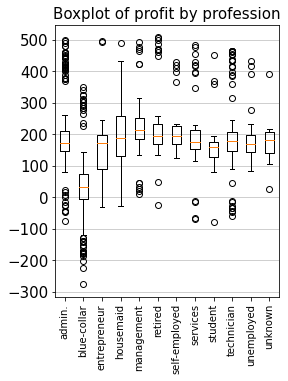

<AxesSubplot:xlabel='profit', ylabel='Density'>

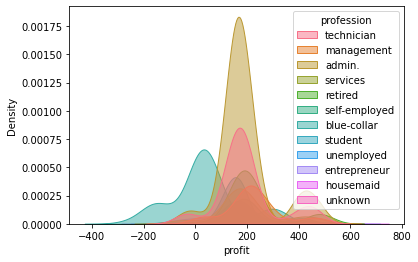

In [24]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'profession')

sns.kdeplot(x = 'profit', 
            hue = 'profession', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Blue-collar professionals are loss making customers to the company. 

### Marital

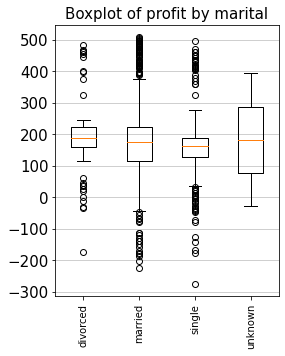

<AxesSubplot:xlabel='profit', ylabel='Density'>

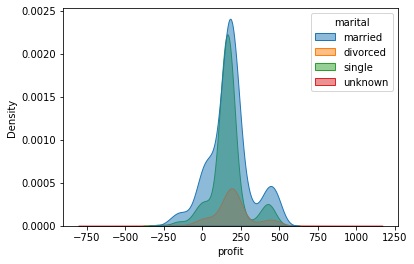

In [25]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'marital')

sns.kdeplot(x = 'profit', 
            hue = 'marital', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Customer with Marital status 'Divorced' (except outliers) are profit making to the firm.

### schooling

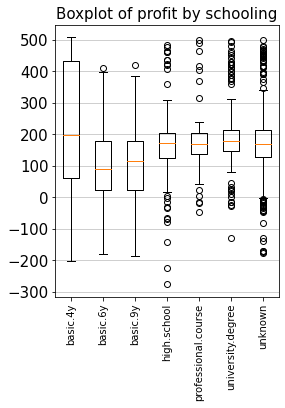

<AxesSubplot:xlabel='profit', ylabel='Density'>

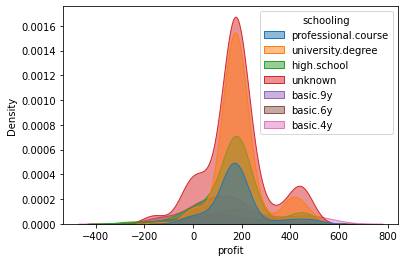

In [26]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'schooling')

sns.kdeplot(x = 'profit', 
            hue = 'schooling', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Customers with education as 'high.school' or 'professional.course' or 'university degree' are rarely loss making. Customers with 'basic.4y' education are having more tendency of being profitable to the firm than rest.

### Default

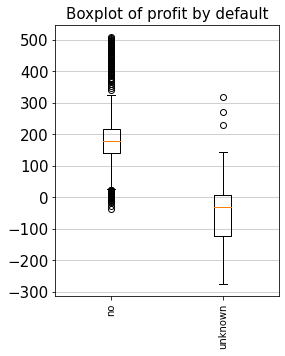

<AxesSubplot:xlabel='profit', ylabel='Density'>

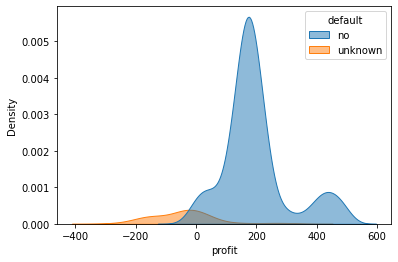

In [27]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'default')

sns.kdeplot(x = 'profit', 
            hue = 'default', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Customers who defaulted on some loan, are more profitable to the firm. 

### Housing

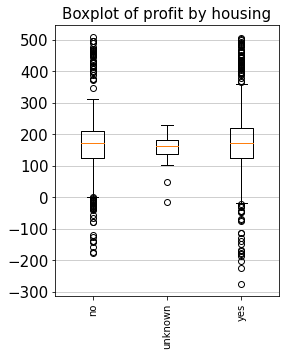

<AxesSubplot:xlabel='profit', ylabel='Density'>

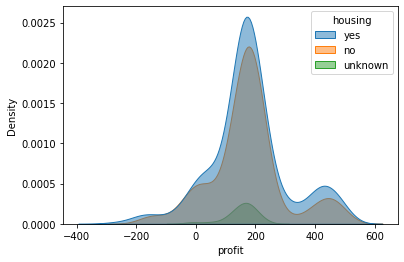

In [28]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'housing')

sns.kdeplot(x = 'profit', 
            hue = 'housing', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

No conclusions can be drawn. Apparently, all have similar distributions.

### Loan

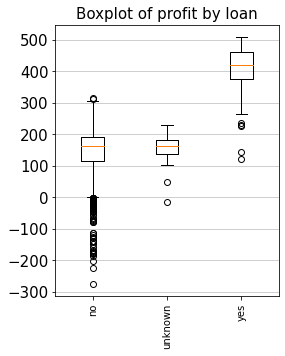

<AxesSubplot:xlabel='profit', ylabel='Density'>

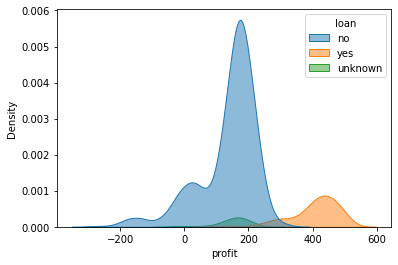

In [29]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'loan')
sns.kdeplot(x = 'profit', 
            hue = 'loan', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Customers with a Personal loan are profit making segments to the firm. 

### Contact

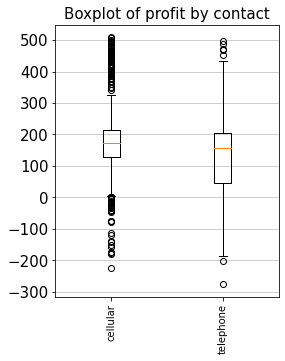

<AxesSubplot:xlabel='profit', ylabel='Density'>

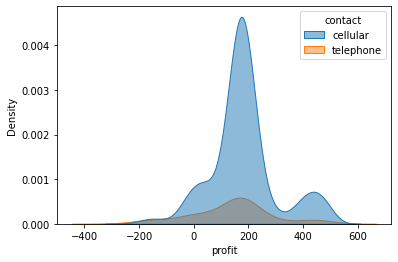

In [30]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'contact')

sns.kdeplot(x = 'profit', 
            hue = 'contact', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Customers preferring Cellular mode of contact have more number of cases who turns to be profitbale then telephonic mode (uniform through out profit distribution).

### Month

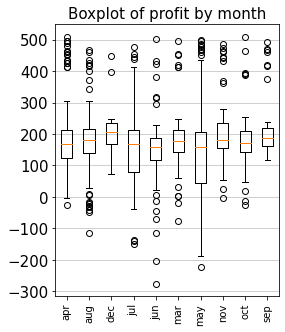

<AxesSubplot:xlabel='profit', ylabel='Density'>

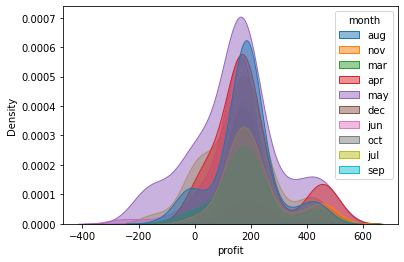

In [31]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'month')

sns.kdeplot(x = 'profit', 
            hue = 'month', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Customers last contacted in May have more chances to be loss making then rest of the months.

### day_of_week

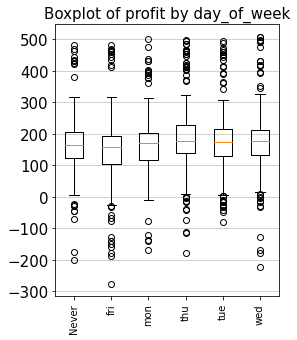

<AxesSubplot:xlabel='profit', ylabel='Density'>

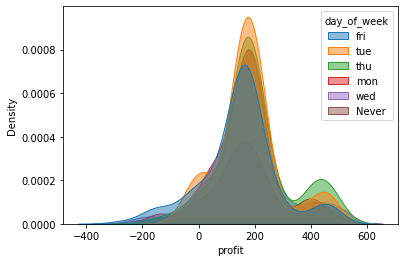

In [32]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'day_of_week')

sns.kdeplot(x = 'profit', 
            hue = 'day_of_week', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

No insights can be drawn. All distributions seem to be similar.

### poutcome

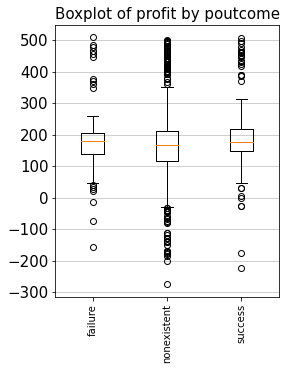

<AxesSubplot:xlabel='profit', ylabel='Density'>

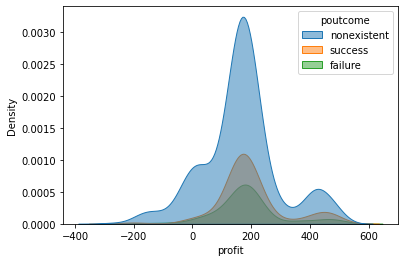

In [33]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'poutcome')

sns.kdeplot(x = 'profit', 
            hue = 'poutcome', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Customer whose previous Campaign outcome is known (success/failure) are more profitable to the firm.

### fl_first_time_contact

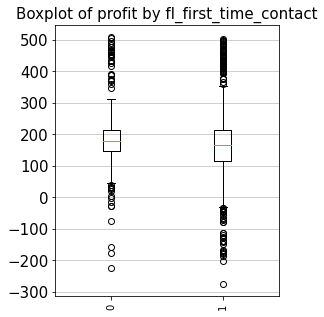

<AxesSubplot:xlabel='profit', ylabel='Density'>

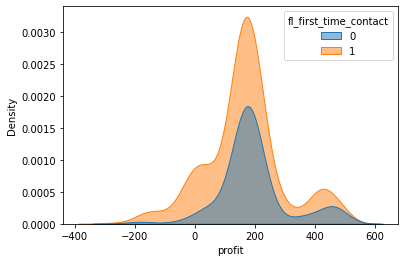

In [34]:
plot_boxplot(df = data_train_1, column = 'profit', by = 'fl_first_time_contact')

sns.kdeplot(x = 'profit', 
            hue = 'fl_first_time_contact', 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Customers who are contacted before are more profitable to the firm. May be because we know their other information like bureau and are contacting them on the basis of it.

## Numeric Variables

### Customer Age (Constant Imputation)

Bins threshold: [-inf, -485.529702970297, 34.36355545666926, 51.85193611291669, inf]


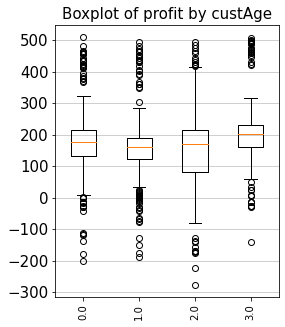

<AxesSubplot:xlabel='profit', ylabel='Density'>

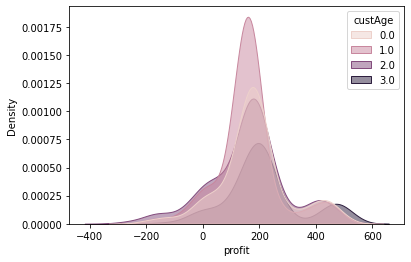

In [35]:
#Constant imputation of Age

feature = 'custAge'
print("Bins threshold: " + str(thold_dict[feature]))
plot_boxplot(df = data_train_1, column = 'profit', by = feature)

sns.kdeplot(x = 'profit', 
            hue = feature, 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Old age customers are most profit making segments to the firm.

### pdays

Bins threshold: [-inf, 9.42424242424238, 18.166666666666686, 510.8333333333332, inf]


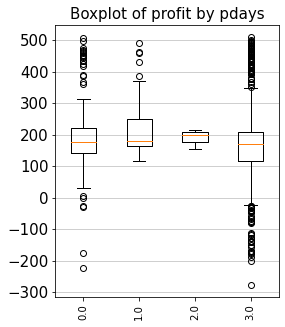

<AxesSubplot:xlabel='profit', ylabel='Density'>

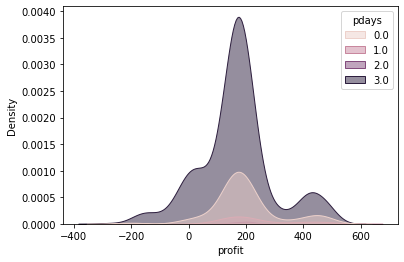

In [36]:
feature = 'pdays'
print("Bins threshold: " + str(thold_dict[feature]))
plot_boxplot(df = data_train_1, column = 'profit', by = feature)

sns.kdeplot(x = 'profit', 
            hue = feature, 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)

Customers who were contacted way back are more profitable. Customers who were never contacted (Bucket 3: 999) are unpredictable (uniform distribtuin across +ve and -ve side).

### pmonths

Bins threshold: [-inf, 0.3768323292416653, 0.6979166664375498, 499.9166666665002, inf]


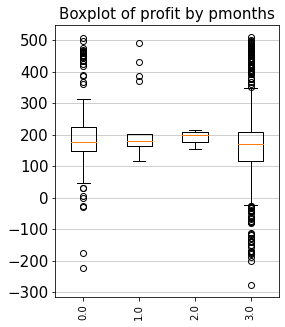

<AxesSubplot:xlabel='profit', ylabel='Density'>

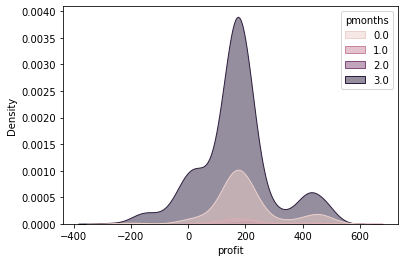

In [37]:
feature = 'pmonths'
print("Bins threshold: " + str(thold_dict[feature]))
plot_boxplot(df = data_train_1, column = 'profit', by = feature)

sns.kdeplot(x = 'profit', 
            hue = feature, 
            data = data_train_1, 
            fill=True, 
            common_norm=True, 
            alpha=.5,
            linewidth=1)



Customers who were contacted way back are more profitable. Customers who were never contacted (Bucket 3: 999) are unpredictable (uniform distribtuin across +ve and -ve side).

## Ordinal variables

### Campaign

<AxesSubplot:xlabel='campaign', ylabel='profit'>

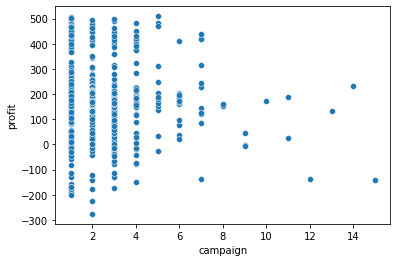

In [38]:
sns.scatterplot(data = data_train_1, x = "campaign", y = "profit")

Higher ther number of campaign done for a customer, lesser loss making they are to the firm.

### Employment Variation Rate 

<AxesSubplot:xlabel='emp.var.rate', ylabel='profit'>

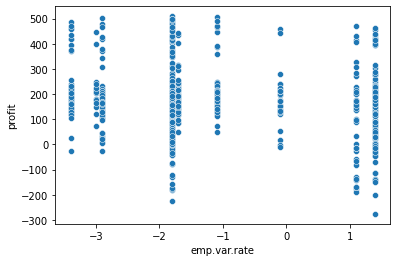

In [39]:
sns.scatterplot(data = data_train_1, x = "emp.var.rate", y = "profit")

Customers who are contacted when employment variation rate was ~-2 or >1 are more potent to loss making. 

### Consumer Price Index 

<AxesSubplot:xlabel='cons.price.idx', ylabel='profit'>

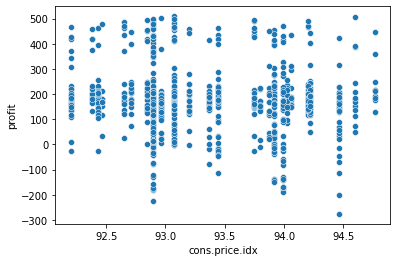

In [40]:
sns.scatterplot(data = data_train_1, x = "cons.price.idx", y = "profit")

Customers who are contacted when consumer price index was ~92.8 or 93.9 or 94 or 95 are more potent to loss making. 

### Consumer Confidence Index 

<AxesSubplot:xlabel='cons.conf.idx', ylabel='profit'>

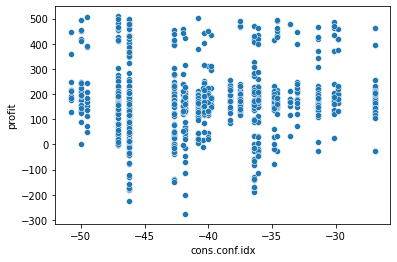

In [41]:
sns.scatterplot(data = data_train_1, x = "cons.conf.idx", y = "profit")

Customers who are contacted when consumer consumer index was -46 or -43 or -36 are more potent to loss making. 

### Euribor 3 Month Rate 

<AxesSubplot:xlabel='euribor3m', ylabel='profit'>

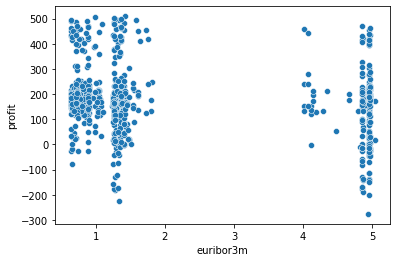

In [42]:
sns.scatterplot(data = data_train_1, x = "euribor3m", y = "profit")

Higher the Euribor 3 Month rate, higher the loss from the customers. 

### Number of employees 

<AxesSubplot:xlabel='nr.employed', ylabel='profit'>

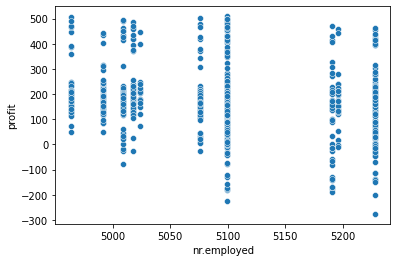

In [43]:
sns.scatterplot(data = data_train_1, x = "nr.employed", y = "profit")

More the number of emplyees employed, higher the loss. May be more number of employees to be paid for a single customer profit

### pastEmail

<AxesSubplot:xlabel='pastEmail', ylabel='profit'>

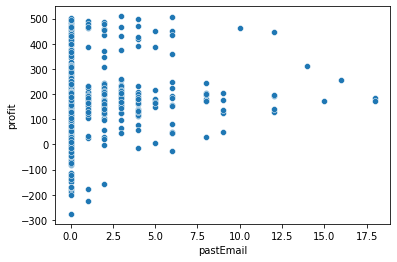

In [44]:
sns.scatterplot(data = data_train_1, x = "pastEmail", y = "profit")

More number of emails sent to a customer, lesser the tendency to loss.

### Previous

<AxesSubplot:xlabel='previous', ylabel='profit'>

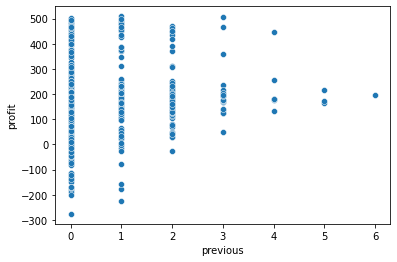

In [45]:
sns.scatterplot(data = data_train_1, x = "previous", y = "profit")

More number of contacts done previously, lesser the tendency to loss.

# Univariate Feature Selection

## 1. Krushal - Wallis Test

This non parametric test can be used to determine whether more than two independent samples have a different distribution. Null hypothesis is that the population medians of all groups are equal. It helps to understand relation of categories in an input feature with target variable.

In [46]:
cols_to_keep, cols_to_drop = krushkal_wallis_test(data = data_train_1,
                                                 features = categorical_var,
                                                 target_var = 'profit',
                                                 alpha = 0.05)

print("Columns shortlisted by Krushkal Test: "+ str(cols_to_keep))
print("\nColumns not useful: "+ str(cols_to_drop))

#dropping not useful columns:
data_train_2 = data_train_1.drop(columns = cols_to_drop)

#removing features from 'cols_to_drop' from the list of categorical variables
for feature in cols_to_drop:
    if feature in categorical_var:
        categorical_var.remove(feature)

Columns shortlisted by Krushkal Test: ['loan', 'contact', 'profession', 'default', 'month', 'marital', 'day_of_week', 'schooling', 'pdays', 'pmonths', 'fl_first_time_contact']

Columns not useful: ['housing', 'poutcome']


The columns shortlisted by Krushal-Wallis Test shows that atleast one of the catgory in these features has different distribution in terms of target variable. 

## 2. Correlation

Correlation is a measure of how two variables change together.

### One Hot Encoding

In [47]:
#One hot encoding categorical variables
data_train_3 = pd.get_dummies(data_train_2, columns = categorical_var)

In [48]:
#performing Correlation test of ordinal variables with target variable
#spearman: as it non parmetric and captures montonic trend
correlation_with_tar_var = data_train_3.drop(columns = ['id','profit']).corrwith(data_train_3['profit'],
                                                                                 method='spearman')  

print("Correlation of ordinal variables with target variable: ")
correlation_with_tar_var.sort_values()

Correlation of ordinal variables with target variable: 


loan_no                  -0.520560
default_unknown          -0.442969
profession_blue-collar   -0.432359
nr.employed              -0.173465
euribor3m                -0.157670
                            ...   
previous                  0.108172
profession_retired        0.149478
profession_management     0.168129
default_no                0.442969
loan_yes                  0.582376
Length: 65, dtype: float64

In [49]:
#filtering columns having very low correlation with target variable.  (> -0.05 & < 0.05)
cols_to_drop = correlation_with_tar_var[(correlation_with_tar_var > -0.05) & (correlation_with_tar_var < 0.05)]

#removing such columns
data_train_3.drop(columns = list(cols_to_drop.index), inplace = True)

#printing dropped columns
print("Dropped following columns because of low correlation with target_var: \n" + str(len(cols_to_drop)))
cols_to_drop

Dropped following columns because of low correlation with target_var: 
24


campaign                        -0.032523
loan_unknown                    -0.036453
profession_entrepreneur         -0.033132
profession_housemaid             0.036999
profession_services              0.046762
profession_unemployed            0.019208
profession_unknown               0.013085
month_apr                        0.020715
month_aug                        0.038343
month_jul                       -0.039606
month_mar                        0.028096
month_oct                        0.016968
marital_married                  0.048951
marital_unknown                 -0.003984
day_of_week_Never               -0.032217
day_of_week_mon                 -0.012553
day_of_week_tue                  0.019937
day_of_week_wed                  0.033621
schooling_high.school           -0.004044
schooling_professional.course   -0.003920
schooling_unknown                0.015812
pdays_2.0                        0.023192
pmonths_1.0                      0.045935
pmonths_2.0                      0

In [50]:
print("Features left: {}".format(data_train_3.shape[1]-2))

Features left: 41


In [51]:
#getting correlation with other variables
corr = data_train_3.drop(columns = ['id', 'profit']).corr()
corr.style.background_gradient(cmap = 'PuBu')

,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,pastEmail,custAge,loan_no,loan_yes,contact_cellular,contact_telephone,profession_admin.,profession_blue-collar,profession_management,profession_retired,profession_self-employed,profession_student,profession_technician,default_no,default_unknown,month_dec,month_jun,month_may,month_nov,month_sep,marital_divorced,marital_single,day_of_week_fri,day_of_week_thu,schooling_basic.4y,schooling_basic.6y,schooling_basic.9y,schooling_university.degree,pdays_0.0,pdays_1.0,pdays_3.0,pmonths_0.0,pmonths_3.0,fl_first_time_contact_0,fl_first_time_contact_1
previous,1.000000,-0.253180,0.113700,0.112252,-0.368717,-0.476151,0.744327,0.009401,-0.025289,-0.014600,0.145818,-0.145818,0.023812,-0.118162,-0.012757,0.095142,-0.064066,0.048786,0.054263,0.101572,-0.101572,0.033399,-0.109134,-0.088017,0.104018,0.176804,0.065832,-0.031066,-0.012950,0.017067,0.066437,-0.032647,-0.056050,0.001244,0.662568,0.210544,-0.732288,0.681887,-0.732288,0.824306,-0.824306
emp.var.rate,-0.253180,1.000000,0.667114,-0.231434,0.921544,0.775283,-0.198548,-0.062656,-0.015950,0.023418,-0.392955,0.392955,-0.041328,0.191161,0.024634,-0.185117,-0.017755,-0.115986,0.015579,-0.282398,0.282398,-0.147254,0.032322,0.062462,-0.071203,-0.132629,0.009289,-0.090696,0.021526,-0.034084,-0.027460,0.082951,0.073850,0.011607,-0.273064,-0.061013,0.281763,-0.272637,0.281763,-0.356745,0.356745
cons.price.idx,0.113700,0.667114,1.000000,-0.254332,0.421991,0.112020,0.071139,-0.045936,-0.005944,-0.004460,-0.335719,0.335719,-0.039592,0.062774,-0.006477,-0.050299,-0.040934,-0.057384,0.007680,-0.134185,0.134185,-0.128213,0.169839,-0.076466,-0.038359,0.037585,0.061569,-0.063392,-0.033272,-0.003783,0.030389,0.036140,-0.023228,0.005398,-0.008292,0.066196,-0.034442,0.001398,-0.034442,-0.047203,0.047203
cons.conf.idx,0.112252,-0.231434,-0.254332,1.000000,-0.086818,-0.213683,0.066719,0.124858,0.028741,-0.032562,-0.064694,0.064694,-0.027478,-0.141030,-0.011430,0.140742,0.023113,0.059485,0.001143,0.025822,-0.025822,0.153870,-0.052642,-0.266583,0.067232,0.250793,-0.033480,-0.040709,0.046048,-0.029600,0.025793,-0.049531,-0.045802,-0.030906,0.203982,0.039534,-0.203751,0.190174,-0.203751,0.177161,-0.177161
euribor3m,-0.368717,0.921544,0.421991,-0.086818,1.000000,0.912375,-0.280420,-0.052617,0.005618,0.013506,-0.446426,0.446426,-0.038694,0.196511,0.043767,-0.190132,0.004046,-0.115807,0.002101,-0.277102,0.277102,-0.105835,0.104411,0.017192,0.012343,-0.191096,-0.020237,-0.090778,0.047895,-0.059458,-0.053747,0.082328,0.086817,0.017799,-0.326700,-0.123742,0.364348,-0.334425,0.364348,-0.436458,0.436458
nr.employed,-0.476151,0.775283,0.112020,-0.213683,0.912375,1.000000,-0.347589,-0.065799,-0.000133,0.023488,-0.339018,0.339018,-0.019423,0.230286,0.046199,-0.219545,0.016869,-0.115270,-0.014220,-0.264525,0.264525,-0.108736,0.116532,0.127718,-0.049714,-0.335171,-0.037425,-0.061208,0.046216,-0.039050,-0.068668,0.090078,0.116557,0.013714,-0.399128,-0.153439,0.451577,-0.407943,0.451577,-0.486680,0.486680
pastEmail,0.744327,-0.198548,0.071139,0.066719,-0.280420,-0.347589,1.000000,-0.010925,-0.063147,0.023208,0.111024,-0.111024,-0.004594,-0.071354,-0.030915,0.095734,-0.048784,0.064813,0.017979,0.071535,-0.071535,0.025955,-0.088389,-0.055731,0.082699,0.059082,0.074052,-0.033855,-0.035298,0.000167,0.115978,0.007519,-0.050841,0.015011,0.556934,0.158986,-0.605010,0.573772,-0.605010,0.630008,-0.630008
custAge,0.009401,-0.062656,-0.045936,0.124858,-0.052617,-0.065799,-0.010925,1.000000,0.012135,0.001773,0.007743,-0.007743,-0.083561,-0.051337,0.074025,0.310326,-0.032110,-0.123409,-0.085763,-0.063909,0.063909,0.067674,-0.021107,-0.040845,0.002886,0.019410,0.185609,-0.274379,0.024982,0.009960,0.131446,-0.015711,-0.033442,-0.111863,0.034552,-0.067215,-0.015878,0.029618,-0.015878,0.030325,-0.030325
loan_no,-0.025289,-0.015950,-0.005944,0.028741,0.005618,-0.000133,-0.063147,0.012135,1.000000,-0.889876,-0.014319,0.014319,0.001721,0.022373,0.017774,0.014741,-0.019280,0.0

Interpretation of above heatmap: eg. 'euribor3m' is highly correalted with 'emp.var.rate' in same direction.

In [52]:
'''removing one of the features having threshold > 0.7'''
data_train_4 = correlation(data_train_3.drop(columns = ['id','profit']), threshold = 0.7)
data_train_4['id'] = data_train_3['id']
data_train_4['profit'] = data_train_3['profit']

#final heat map of correlation
corr = data_train_4.drop(columns = ['id', 'profit']).corr()
corr.style.background_gradient(cmap = 'PuBu')

,previous,emp.var.rate,cons.price.idx,cons.conf.idx,custAge,loan_no,contact_cellular,profession_admin.,profession_blue-collar,profession_management,profession_retired,profession_self-employed,profession_student,profession_technician,default_no,month_dec,month_jun,month_may,month_nov,month_sep,marital_divorced,marital_single,day_of_week_fri,day_of_week_thu,schooling_basic.4y,schooling_basic.6y,schooling_basic.9y,schooling_university.degree,pdays_0.0,pdays_1.0
previous,1.000000,-0.253180,0.113700,0.112252,0.009401,-0.025289,0.145818,0.023812,-0.118162,-0.012757,0.095142,-0.064066,0.048786,0.054263,0.101572,0.033399,-0.109134,-0.088017,0.104018,0.176804,0.065832,-0.031066,-0.012950,0.017067,0.066437,-0.032647,-0.056050,0.001244,0.662568,0.210544
emp.var.rate,-0.253180,1.000000,0.667114,-0.231434,-0.062656,-0.015950,-0.392955,-0.041328,0.191161,0.024634,-0.185117,-0.017755,-0.115986,0.015579,-0.282398,-0.147254,0.032322,0.062462,-0.071203,-0.132629,0.009289,-0.090696,0.021526,-0.034084,-0.027460,0.082951,0.073850,0.011607,-0.273064,-0.061013
cons.price.idx,0.113700,0.667114,1.000000,-0.254332,-0.045936,-0.005944,-0.335719,-0.039592,0.062774,-0.006477,-0.050299,-0.040934,-0.057384,0.007680,-0.134185,-0.128213,0.169839,-0.076466,-0.038359,0.037585,0.061569,-0.063392,-0.033272,-0.003783,0.030389,0.036140,-0.023228,0.005398,-0.008292,0.066196
cons.conf.idx,0.112252,-0.231434,-0.254332,1.000000,0.124858,0.028741,-0.064694,-0.027478,-0.141030,-0.011430,0.140742,0.023113,0.059485,0.001143,0.025822,0.153870,-0.052642,-0.266583,0.067232,0.250793,-0.033480,-0.040709,0.046048,-0.029600,0.025793,-0.049531,-0.045802,-0.030906,0.203982,0.039534
custAge,0.009401,-0.062656,-0.045936,0.124858,1.000000,0.012135,0.007743,-0.083561,-0.051337,0.074025,0.310326,-0.032110,-0.123409,-0.085763,-0.063909,0.067674,-0.021107,-0.040845,0.002886,0.019410,0.185609,-0.274379,0.024982,0.009960,0.131446,-0.015711,-0.033442,-0.111863,0.034552,-0.067215
loan_no,-0.025289,-0.015950,-0.005944,0.028741,0.012135,1.000000,-0.014319,0.001721,0.022373,0.017774,0.014741,-0.019280,0.004504,-0.034024,-0.059665,0.009657,0.049887,-0.047321,0.002287,-0.026951,0.018152,0.047494,0.063429,-0.061495,-0.136197,0.001495,0.025926,0.003568,-0.034973,-0.053073
contact_cellular,0.145818,-0.392955,-0.335719,-0.064694,0.007743,-0.014319,1.000000,0.044188,-0.120406,-0.049572,0.062675,-0.019999,0.078275,0.077571,0.189665,0.009231,-0.222738,-0.164044,0.028192,0.080256,0.005505,0.073578,-0.036524,0.005342,-0.020649,-0.038527,-0.039314,0.040735,0.128509,0.062123
profession_admin.,0.023812,-0.041328,-0.039592,-0.027478,-0.083561,0.001721,0.044188,1.000000,-0.272500,-0.176125,-0.194398,-0.125684,-0.154473,-0.272500,0.095261,-0.044282,-0.019473,-0.036141,-0.030996,0.027627,-0.006357,0.137287,-0.042901,0.038831,-0.146227,-0.081525,-0.129970,0.240181,-0.028887,0.026724
profession_blue-collar,-0.118162,0.191161,0.062774,-0.141030,-0.051337,0.022373,-0.120406,-0.272500,1.000000,-0.115934,-0.127962,-0.082731,-0.101682,-0.179372,-0.175153,-0.030190,0.021746,0.186692,-0.086842,-0.113652,-0.075721,-0.109805,0.021638,-0.010004,0.093685,0.192150,0.308970,-0.236161,-0.084821,-0.076613
profession_management,-0.012757,0.024634,-0.006477,-0.011430,0.074025,0.017774,-0.049572,-0.176125,-0.115934,1.000000,-0.082706,-0.053472,-0.065720,-0.115934,-0.018274,0.038607,0.032022,-0.060149,0.044069,0.006073,-0.002705,-0.095777,0.033202,-0.057997,-0.067321,-0.019504,-0.058899,0.244551,0.035189,-0.049517


In [53]:
print("Features left: {}".format(data_train_4.shape[1]-2))

Features left: 30


# Hypothesis Formation (Model Training)

## Building Model Pipeline

In [54]:
'''Build pipline of classifiers'''
# set all CPU
n_jobs = -1
random_state = 1000

# Ordinary least squares Linear Regression
pipe_ols = Pipeline([('ols', LinearRegression(normalize = True, n_jobs=n_jobs))])

#Linear least squares with l1 regularization
pipe_lasso = Pipeline([('lasso', Lasso(random_state = random_state, normalize = True))])

#Linear least squares with l2 regularization
pipe_ridge = Pipeline([('ridge', Ridge(random_state = random_state, normalize = True))])

# Decision Tree Regressor
pipe_dt = Pipeline([('dt', DecisionTreeRegressor(random_state = random_state, max_features = 'auto'))])

# Random Forest Regressor
pipe_rf = Pipeline([('rf', RandomForestRegressor(random_state = random_state, oob_score = True, n_jobs = n_jobs))])


In [55]:
'''Set parameters for Grid Search '''

# set number of splits
n_splits = 5
cv = StratifiedKFold(shuffle=True, n_splits=n_splits, random_state=random_state)

# set for Ordinary Least Square Linear Regression
grid_params_ols = [{}]


# set for lasso linear regression
grid_params_lasso = [{
                    'lasso__alpha': [0.001, 0.1, 1, 10, 100, 1000],
                    'lasso__max_iter': [50, 100, 300, 500, 800, 1000],
                    'lasso__selection': ['cyclic', 'random']
                    }]

# set for Ridge linear regression
grid_params_ridge = [{
                    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 1000],
                    'ridge__max_iter': [50, 100, 300, 500, 800, 1000]
                    }]

# set for KNeighborsClassifier
grid_params_ridge = [{
                    'ridge__alpha': [0.1, 1, 10, 100, 1000],
                    'ridge__max_iter': [50, 100, 300, 500, 800, 1000]
                    }]

# set for DecisionTreeClassifier
grid_params_dt = [{
                'dt__max_depth': np.arange(3,8,1),
                'dt__min_samples_leaf': [40, 47, 50, 55, 60], #must be alteast 5% of total population (789 cases).
                 }]

# set for RandomForestClassifier
grid_params_rf = [{
                'rf__min_samples_leaf': [40, 47, 50, 55, 60], #must be alteast 5% of total population (789 cases),
                'rf__max_depth': np.arange(3,8,1),
                'rf__n_estimators' : [25, 50, 75, 100, 250, 500],
                 }]

In [56]:
'''Grid search objects'''

"""
Using R2 for Scoring. 
"""

# for Ordinary Least Square Linear Regression
gs_ols = GridSearchCV(pipe_ols, param_grid = grid_params_ols,
                      scoring = 'r2', cv=cv) 

# for Lasso Linear Regression
gs_lasso = GridSearchCV(pipe_lasso, param_grid = grid_params_lasso,
                        scoring = 'r2', cv=cv)

# for Ridge Linear Regression
gs_ridge = GridSearchCV(pipe_ridge, param_grid = grid_params_ridge,
                        scoring = 'r2', cv=cv)

# for DecisionTree
gs_dt = GridSearchCV(pipe_dt, param_grid = grid_params_dt,
                     scoring = 'r2', cv=cv)

# for Random Forest
gs_rf = GridSearchCV(pipe_rf, param_grid = grid_params_rf,
                     scoring = 'r2', cv=cv)

## Training and evaluating Model

Using R2 for scoring

+++++++ Start New Model ++++++++++++++++++++++
Estimator is Ordinary_Least_Square
---------------------------------------------
best params {}
best score (r2) is 0.8131
Best param CV test results (r2): mean: 0.8131 | std : 0.035 | min : 0.7673 | max : 0.8667
---------------------------------------------
For complete train set:
r2 = 0.831 
adj_r2 = 0.8243 
MAE = 36.178
It lasted for 0.132 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model ++++++++++++++++++++++
Estimator is Lasso
---------------------------------------------
best params {'lasso__alpha': 0.1, 'lasso__max_iter': 50, 'lasso__selection': 'cyclic'}
best score (r2) is 0.8161
Best param CV test results (r2): mean: 0.8161 | std : 0.0322 | min : 0.7724 | max : 0.8655
---------------------------------------------
For complete train set:
r2 = 0.8234 
adj_r2 = 0.8164 
MAE = 37.2088
It lasted for 4.545 sec
++++++++ End Model +++++++++++++++++++++++++++



+++++++ Start New Model +++++

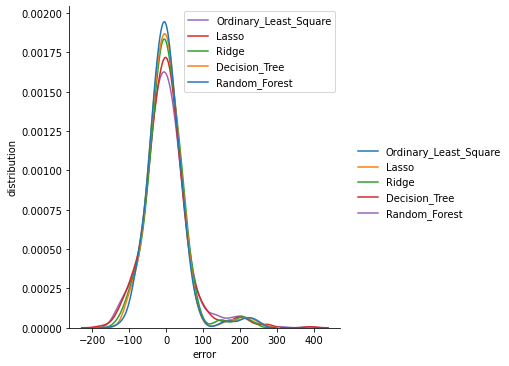

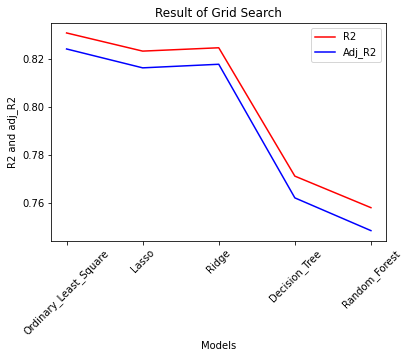

In [57]:
# models that we iterate over
look_for = [gs_ols, gs_lasso, gs_ridge, gs_dt, gs_rf]
# dict for later use 
model_dict = {0:'Ordinary_Least_Square', 1:'Lasso', 2:'Ridge', 3:'Decision_Tree', 4: 'Random_Forest'}

#Function to iterate over regression models and obtain results
models, predictions_df, delta_df, result_r2, result_adj_r2, result_mae = train_regression_model(data = data_train_4.drop(columns = ['id']),
                                                                                               target_var = 'profit',
                                                                                               look_for = look_for,
                                                                                               model_dict = model_dict)

with open(path + "pickle_profit/best_models.p", "wb") as f:
    pickle.dump(models, f)
    
predictions_df.to_pickle(path + "pickle_profit/predictions_from_best_models.p")

above plot is showing performance (R2 and adj_R2) of the best model for each algorithms.

As R2 and adj_R2 are parallel, we can consider R2 as a reliable model performance metric. 

## Conclusion - for chossing the best model

From the above graph, it seems like Ordinary_Least_Square Linear Regression has the best R2 or adj_r2 score. But when we look at the Model CV test results and compare it with Complete train results, Lasso has the least delta between those scores and also std of CV test result is low compared to rest of the model. Hence, moving ahead with Lasso model.

## Analysing and Improving Lasso Linear Regression

In [58]:
'''Getting Model Co-efficients'''

#getting the trained log_reg model from 'models' list
lasso = models[1].steps[0][1]  # 0th index is logistic regression

with open(path + "pickle_profit/lasso.p", "wb") as f:
    pickle.dump(lasso, f)
    
#get co-efficients from model
model_coef = pd.DataFrame(data_train_4.drop(columns = ['id','profit']).columns, columns = ['features'])
model_coef['coef'] = lasso.coef_

#displaying the coefficients of the model in sorted order.
model_coef.sort_values(by = ['features','coef'])

,features,coef
3,cons.conf.idx,-0.000000
2,cons.price.idx,-0.000000
6,contact_cellular,0.000000
4,custAge,2.871502
22,day_of_week_fri,-0.000000
23,day_of_week_thu,0.677925
14,default_no,187.707781
1,emp.var.rate,-0.000000
5,loan_no,-204.528693
20,marital_divorced,0.305330


Lookin at the above co-efficients, we can remove less important ones and try to optimize the model. 

We can remove features having lower co-efficients (i.e. > -0.1 and < 0.1)

In [59]:
''' Removing Features having lower co-efficients (i.e. > -5 and < 5) '''
columns_to_drop = model_coef[((model_coef.coef > -5) & (model_coef.coef < 5))].features    #less important features as per the model

data_train_5 = data_train_4.drop(columns = columns_to_drop)

print("Earlier, we had {} features for first iteration of Model Training,\nNow we have {} for second itertion of Logistic Regression Model training".format(data_train_4.shape[1]-2,data_train_5.shape[1]-2))

columns = list(data_train_5.drop(columns = ['id','profit']).columns)

with open(path + "pickle_profit/final_features.p", "wb") as f:
    pickle.dump(columns, f)

Earlier, we had 30 features for first iteration of Model Training,
Now we have 8 for second itertion of Logistic Regression Model training


Using R2 for scoring

+++++++ Start New Model ++++++++++++++++++++++
Estimator is lasso
---------------------------------------------
best params {'lasso__alpha': 0.001, 'lasso__max_iter': 50, 'lasso__selection': 'random'}
best score (r2) is 0.8201
Best param CV test results (r2): mean: 0.8201 | std : 0.0314 | min : 0.7808 | max : 0.8721
---------------------------------------------
For complete train set:
r2 = 0.8252 
adj_r2 = 0.8234 
MAE = 36.5915
It lasted for 2.487 sec
++++++++ End Model +++++++++++++++++++++++++++




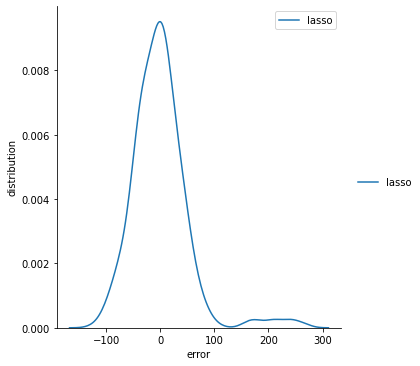

In [61]:
'''re-training logistic regression model'''

# models that we iterate over, this time iterating over logistic regression only.
look_for = [gs_lasso]
# dict for later use 
model_dict = {0:'lasso'}


#Function to iterate over model and obtain results
models_1, predictions_df_1, delta_df_1, result_r2_1, result_adj_r2_1, result_mae_1 = train_regression_model(data = data_train_5.drop(columns = ['id']),
                                                                                                           target_var = 'profit',
                                                                                                           look_for = look_for,
                                                                                                           model_dict = model_dict)


with open(path + "pickle_profit/best_models_1.p", "wb") as f:
    pickle.dump(models_1, f)
    
predictions_df_1.to_pickle(path + "pickle_profit/predictions_from_best_models.p")

It is observed that, there has been a decrease in delta between R2 of complete train set and mean cv test score, without dropping overall model performance. 
i.e. earlier: (0.816, 0.822)  ---> now: (0.8252, 0.8201) 

Note: first value in tuple indicates train score and second value in tuple indicates mean cv test score.

Also Standard Deviation of CV test score has come down to 0.0314 from 0.0321

This means, we have succefully optimized the model (lesser features, bit better performance).

In [73]:
'''Getting Model Co-efficients of recent logistic regression'''

#getting the trained log_reg model from 'models' list
lasso_final = models_1[0].steps[0][1]  # 0th index is logistic regression

#saving as pickle
with open(path + "pickle_profit/lasso_final.p", "wb") as f:
    pickle.dump(lasso_final, f)
    
prediction_train = data_train_5[['id','profit']] 
prediction_train['pred_profit'] = lasso_final.predict(data_train_5.drop(columns = ['id','profit']))

#saving prediction dataframe for PSI comparison during tagging batches:
prediction_train.to_pickle(path + "pickle_profit/prediction_train.p")
    
#get co-efficients from model
model_coef_final = pd.DataFrame(data_train_5.drop(columns = ['id','profit']).columns, columns = ['features'])
model_coef_final['coef'] = lasso_final.coef_

#displaying the coefficients of the model in sorted order.
model_coef_final.sort_values(by = ['features','coef'])

,features,coef
5,default_no,196.289938
0,loan_no,-210.356057
6,marital_single,-16.405281
1,profession_blue-collar,-132.351078
2,profession_management,40.720970
3,profession_retired,16.273201
4,profession_student,-29.194470
7,schooling_basic.4y,25.379663


Prediction Interval: 

A prediction interval for a single future observation is an interval that will, with a specified degree of confidence, contain a future randomly selected observation from a distribution

Prediction interval is calculated as 1.96 * std_dev...
Prediction Interval: Â± 105.400

Percentage of points lying in 95% prediction interval for this population: 96.32%


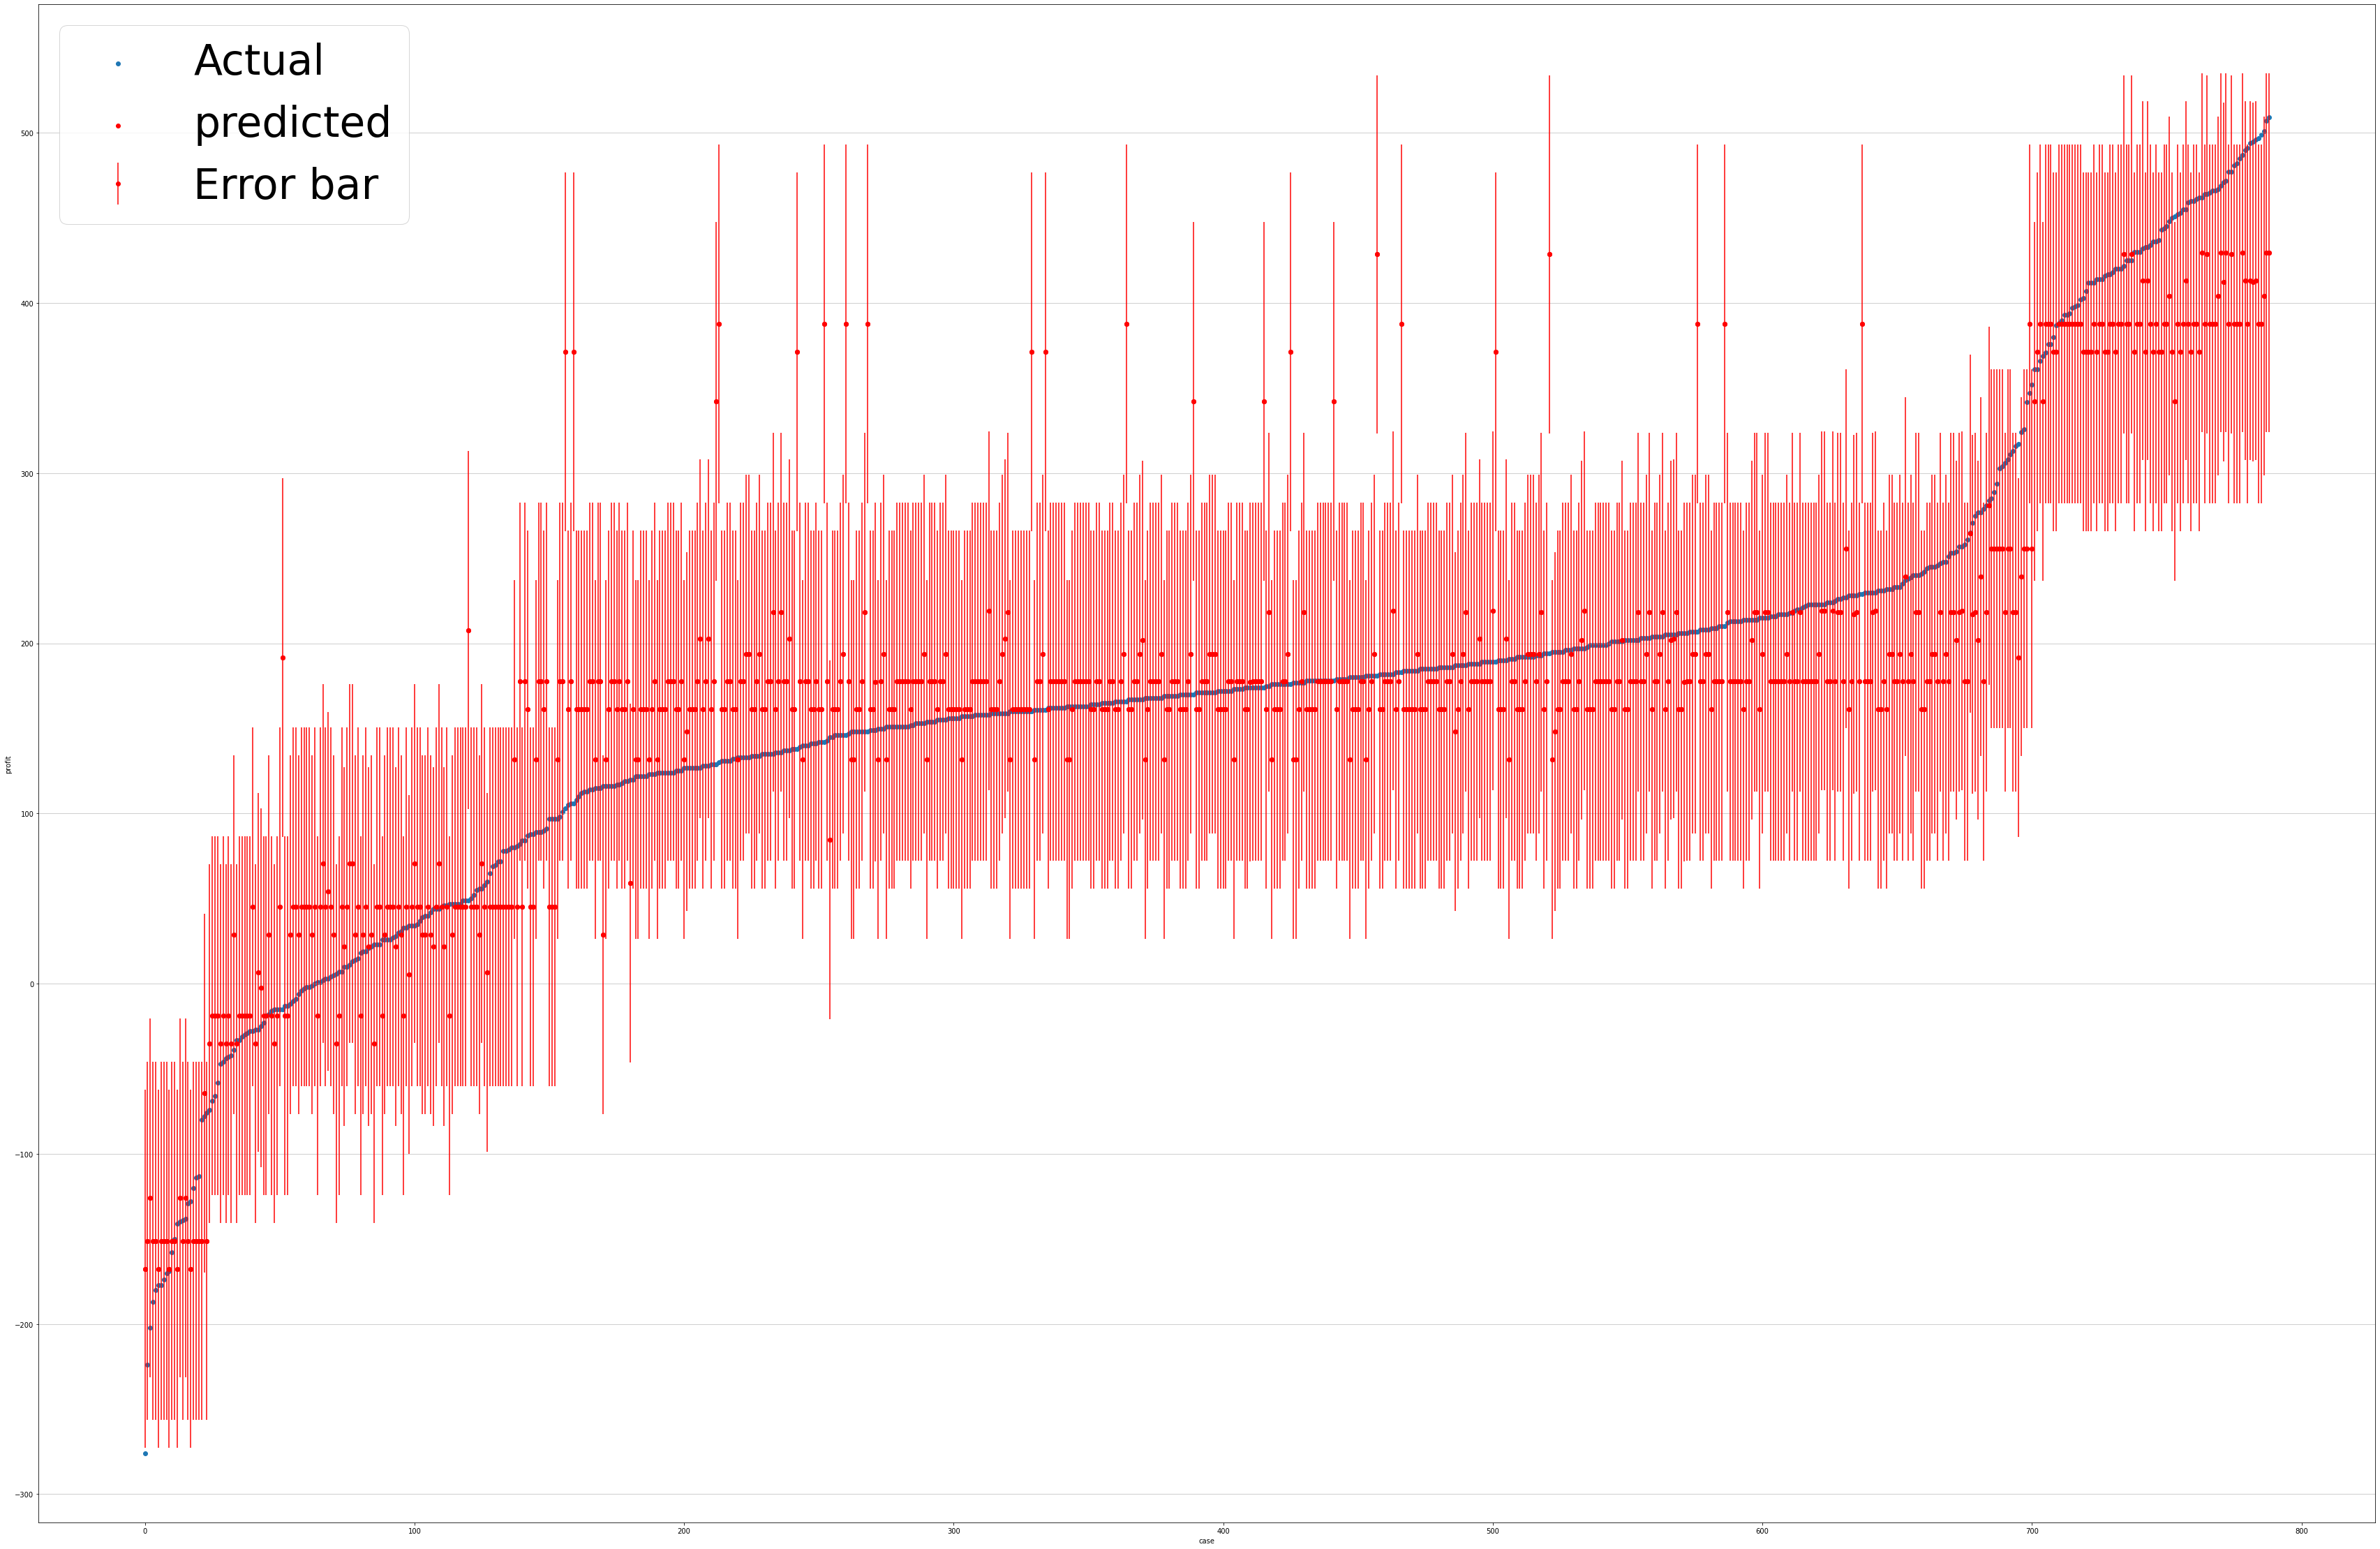

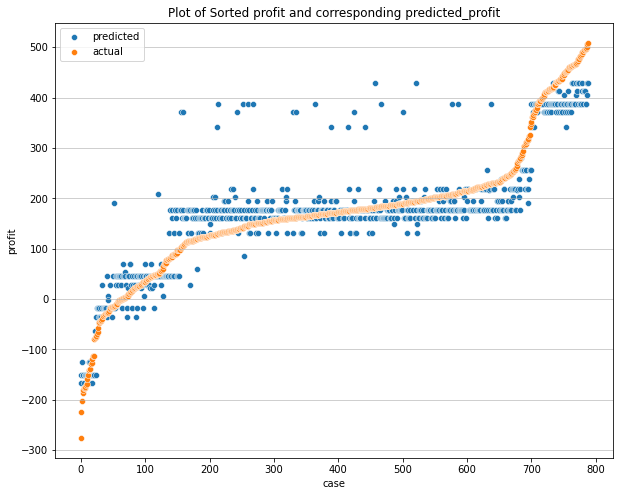

In [63]:
'''Function to plot prediction interval for regression outputs''' 
plot_prediction_interval(y = prediction_train['profit'],
                         y_pred = prediction_train['pred_profit'],
                         target_var = 'profit')

# Testing

In [64]:
'''Loading test data'''
data_test = pd.read_pickle(path + "pickle_profit/data_test.p")

#nominal features in model
nominal_features = ['default', 'loan', 'marital', 'profession', 'schooling']

'''Null Imputation'''
data_test['schooling'] = np.where(data_test['schooling'].isna(), 'unknown', data_test['schooling'])

#keeping only relevant features
data_test = data_test[['id','profit'] + nominal_features]

In [65]:
'''
Below snippet is useful when a feature in a test set has an additional category which was never faced in train set, 
hence removing it after one_hot_encoding. To make sure whatever category where there in train are present in test,
we append test_ohe to structure of train_ohe dataframe and impute missing value with zero.
'''

#getting final one hot encoded features from model
with open(path + "pickle_profit/final_features.p", "rb") as f:
    final_model_features = pickle.load(f)
    
final_model_features.append('id')
final_model_features.append('profit') 

#creating an empty dataframe which will have one hot encoded data, of similar structure from training time.
data_test_ohe = pd.DataFrame(columns = final_model_features)

#one hot encoding nominal features of testing data.
data_test_ohe_temp = pd.get_dummies(data_test, columns = nominal_features)

#identifying and removing columns which are created for unseen category during training time. 
unnecessary_col = []
for feature in data_test_ohe_temp.columns:
    if feature not in final_model_features:
        unnecessary_col.append(feature)
        
data_test_ohe_temp.drop(columns = unnecessary_col, inplace = True)

#appending test one hot encoded data to above empty dataframe having training data structure.
data_test_ohe = data_test_ohe.append(data_test_ohe_temp)

#if some category was present in train data but not in test, then Null would appear after above step
#hence replacing null with zero
data_test_ohe.fillna(value = 0, inplace = True)

In [72]:
'''getting Model output and performance for Test set'''

with open(path + "pickle_profit/lasso_final.p", "rb") as f:
    lasso_final = pickle.load(f)

#getting prediction
X_test = data_test_ohe.drop(columns = ['id','profit'])

prediction_test = data_test_ohe[['id','profit']]    
prediction_test['pred_profit'] = lasso_final.predict(X_test)

#Model performance on complete train set 
mae = round(mean_absolute_error(prediction_test['profit'], prediction_test['pred_profit']), 4)
r2 = round(r2_score(prediction_test['profit'], prediction_test['pred_profit']), 4)

#adj_r2
n = len(X_test) #number of cases
p = len(X_test.columns)  #number of features 
adj_r2 = round(1-(1-r2)*(n-1)/(n-p-1), 4)

print('---------------------------------------------')
print('For test set:')
print('r2 = {} \nadj_r2 = {} \nMAE = {}'.format(r2, adj_r2, mae))


---------------------------------------------
For test set:
r2 = 0.8543 
adj_r2 = 0.8453 
MAE = 39.5801


For trainig set, R2 for Complete train set was 0.8252 and mean CV test score as 0.8201.
For test set, R2 is 0.8543. So this model holds for test set as well.

Prediction Interval: 

A prediction interval for a single future observation is an interval that will, with a specified degree of confidence, contain a future randomly selected observation from a distribution
Prediction Interval: Â± 105.400

Percentage of points lying in 95% prediction interval for this population: 97.84%


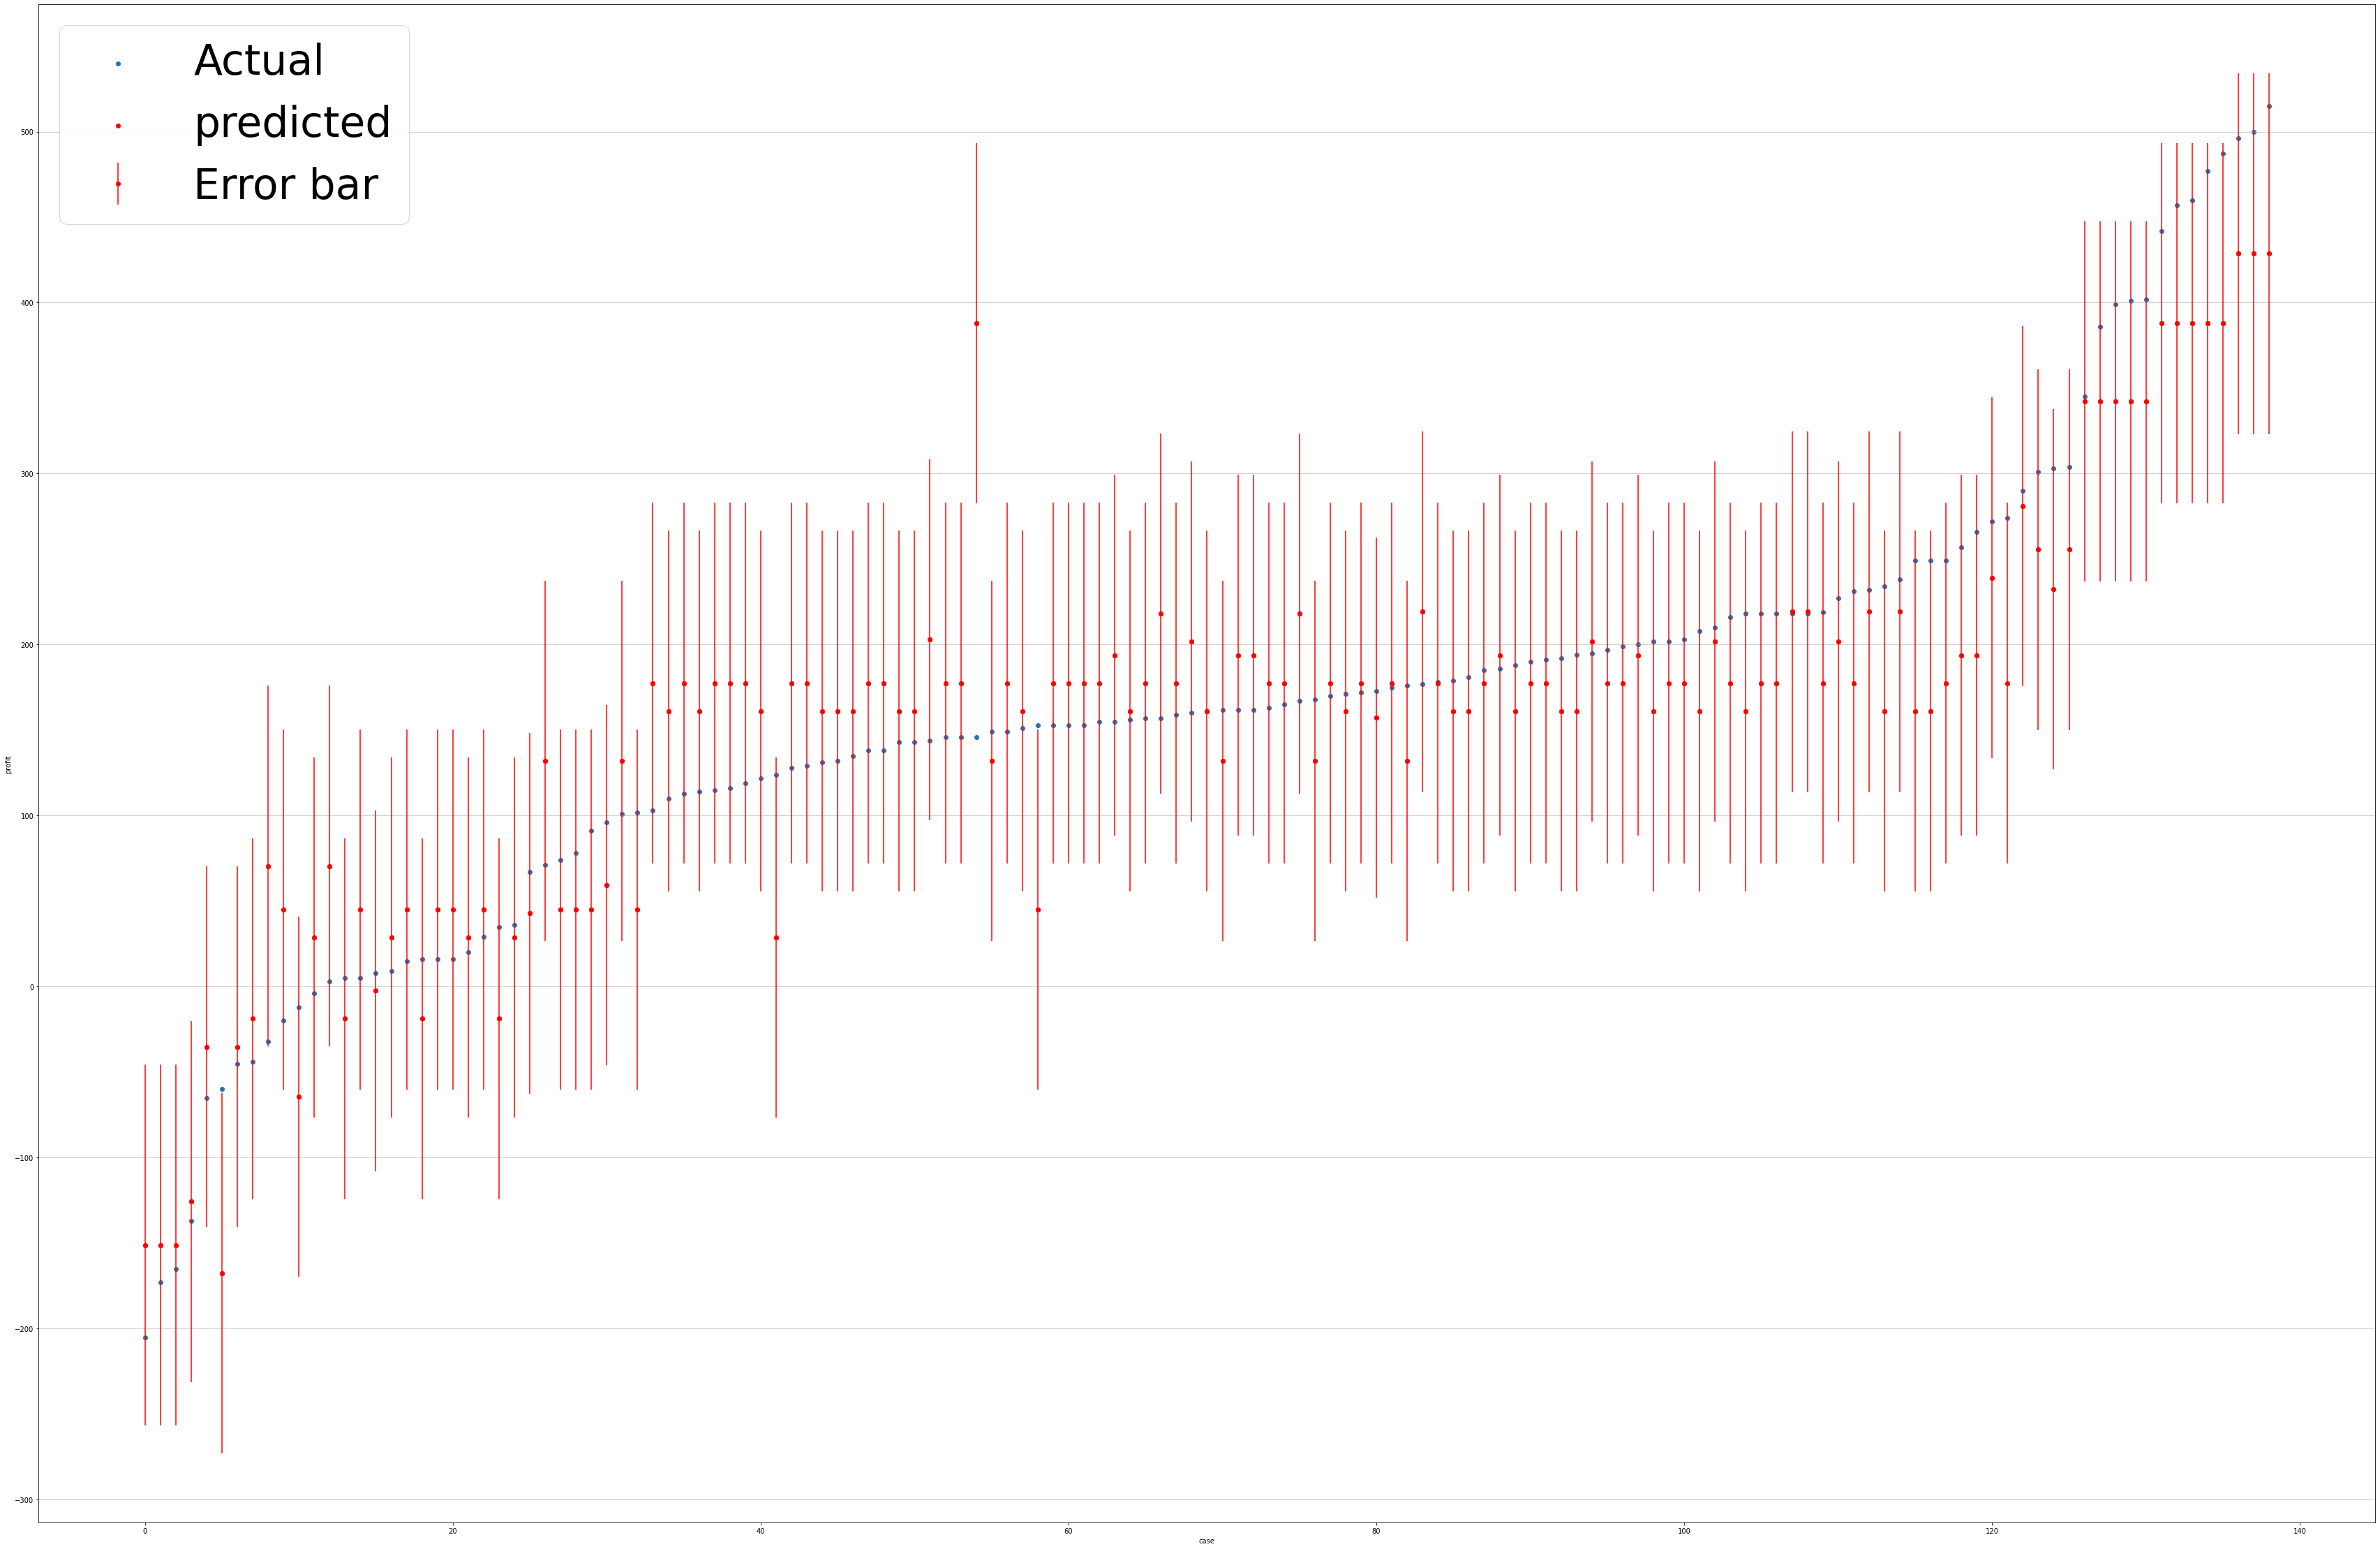

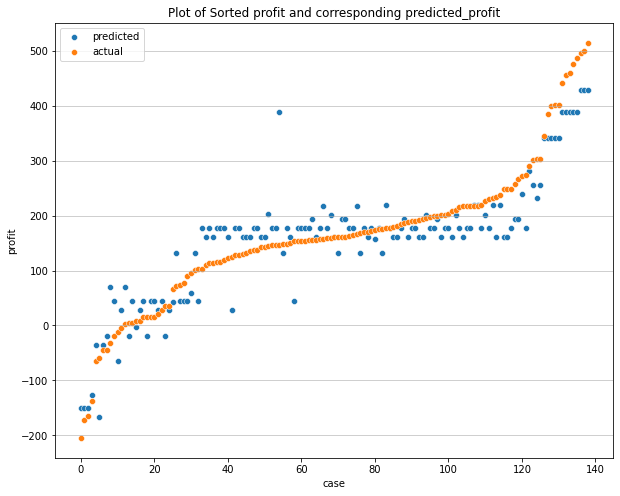

In [67]:
'''Function to plot prediction interval for regression outputs''' 
plot_prediction_interval(y = prediction_test['profit'],
                         y_pred = prediction_test['pred_profit'],
                         target_var = 'profit',
                         is_train = False,
                         interval = 105.400)

The above results shows that 97% of the predicted profits are in prediction interval.

# Conclusion: to optimize the profit

To optimize the profit during the campaign, we can shortlist customers whose Model predicted atleast 106 profit. Because, we saw that ~96% of customers whose profit is predicted falls in the range of 95% Prediction interval. i.e. Even if a person's profit is predicted as 106 (actual profit is 1) we will be on safer side.  